Importamos las librerias a utilizar

In [1]:
import pandas as pd
import os
import glob

Damos la ruta de los archivos

In [2]:
path = 'Etiquetas'

Cargamos nuestros archivos

In [3]:
files = os.path.join("Etiquetas", "*.csv")
files = glob.glob(files)
df = pd.concat(map(pd.read_csv, files), ignore_index=False)
df = df[["etiqueta", "x1", "y1", "x2", "y2", "imagen", "w", "h"]]

Creamos la funcion para extraer los valores de la imagen

In [4]:
# Funcion para extraer la subcadena i-esima de la tupla
def parametroImagen(subCadena):
    """ 
    Documentar lo siguiente
    Input:
    -------    
    Output:    
    """
    Pc = 1
    c1, c2, c3, c4 = 0, 0, 0, 0
    if subCadena[0] == 'linea_carril': 
        c1 = 1
    elif subCadena[0] == 'linea_emergencia': 
        c2 = 1  
    elif subCadena[0] == 'borde_izquierdo': 
        c3 = 1
    elif subCadena[0] == 'borde_derecho': 
        c4 = 1
    x1 = subCadena[1]
    y1 = subCadena[2]
    x2 = subCadena[3]
    y2 = subCadena[4]
    w =  subCadena[6]
    h = subCadena[7]
    return [Pc, c1, c2, c3, c4, x1, y1, x2, y2]

Ahora vamos a juntar en un solo arreglo los datos que correspondan a la misma imagen

In [5]:
# Creamos una lista con los nombres de las imagenes (sin repetir)
nombres  = df['imagen'].unique()
repeticionesPorImagen = []
datosImagenes = []

for nombre in nombres:
    repeticionesPorImagen.append(list(df['imagen']).count(nombre))

# Aqui vamos a crear un arreglo con los datos de una misma imagen
# para recorrernos en todas las imagenes usaremos slices del tipo [n, n + x].
n = 0
pivote = 0
for pivoteTemp in repeticionesPorImagen:
    pivote = pivoteTemp + n
    datosImagenes.append(df[n:pivote].to_numpy())
    n += pivoteTemp

Vectores generales

In [6]:
datosImagenes[0][1][5]

'2019_10_26_120345_001_resized.png'

In [7]:
VectorGeneral = []
VectorTemp = []
flagEmergencia = 0
lineasTotales = 7

# Cargamos las dimensiones de las imagenes de cualquier arreglo
w = datosImagenes[0][0][-2]
h = datosImagenes[0][0][-1]

# Iteramos sobre el numero de datos de imagenes que tenemos
# en este caso son 972
for i in range(len(datosImagenes)):
    # Aqui vamos a iterar sobre los arreglos de datos de cada imagen
    for j in range(len(datosImagenes[i])):   
        # Extraemos la fila de parametros de la imagen dada una etiqueta
        datosImagenVec = parametroImagen(datosImagenes[i][j])
        VectorTemp.append(datosImagenVec)
        # Banderas de BordeIzquierdo, BordeDerecho y LineaDeEmergencia
        flagEmergencia = datosImagenVec[2]
        flagBordeIzquierdo = datosImagenVec[3]
        flagBordeDerecho = datosImagenVec[4]     
    while len(VectorTemp) < lineasTotales:
        # Aqui verificamos si ya tenemos un registro de linea de emergencia
        if flagEmergencia == 0:
            VectorTemp.append([0, 1, 0, 0, 0, 0, 0, 0, 0])
            flagBordeDerecho = 1
        # Aqui verificamos si ya tenemos un registro de borde derecho
        elif flagBordeDerecho == 0:
            VectorTemp.append([0, 0, 0, 0, 1, 0, 0, 0, 0])
            flagBordeDerecho = 1
        # Aqui verificamos si ya tenemos un registro de borde izquierdo
        elif flagBordeIzquierdo == 0:
            VectorTemp.append([0, 0, 0, 1, 0, 0, 0, 0, 0])
            flagBordeIzquierdo = 1
        # Por ultimo agregamos las lineas de carril en las posiciones sobrantes
        else:
            VectorTemp.append([0, 0, 1, 0, 0, 0, 0, 0, 0])
            flagEmergencia = 1 # Dado que ya habremos agregado la linea de Emergancia           
    nombreImagen = [datosImagenes[i][j][5]]
    VectorTemp.append(nombreImagen) # Le pasamos el nombre de la imagen
    VectorGeneral.append(VectorTemp) # Cargamos la fila de valores al VectorGeneral
    VectorTemp = [] # Reseteamos nuestro vector temporal    
    
# Aplanado del vector
VectorGeneralAplanado = []
flat_list = []

for item in VectorGeneral:
    for l in item:
        flat_list += l
    flat_list.extend([w, h])
    VectorGeneralAplanado.append(flat_list)
    flat_list = []

De modo que tenemos el siguiente vector para la imagen No.941

In [152]:
imagenes = VectorGeneral

Ahora vemos el vector aplanado

In [9]:
print(VectorGeneralAplanado[911])

[1, 0, 0, 1, 0, 7, 418, 342, 367, 1, 0, 0, 0, 1, 909, 402, 591, 358, 1, 1, 0, 0, 0, 260, 497, 411, 383, 1, 1, 0, 0, 0, 298, 494, 421, 384, 1, 1, 0, 0, 0, 723, 478, 524, 376, 1, 1, 0, 0, 0, 907, 422, 586, 367, 0, 1, 0, 0, 0, 0, 0, 0, 0, '2019_12_08_222329_006_resized.png', 960.0, 540]


## TODO:
-  ~~Dejar solo un parametro $w$ y $h$ para el arreglo __Prueba[i]__~~
- ~~Determinar como calcular $P_c$~~
- ~~Asegurarse de que cada $i$-esimo subtable de la tabla general contenga 65 elementos~~
- ~~Refactorizar y simplificar codigo existente~~
- ~Escribir $\LaTeX$~
- Documentar

---

## Dibujado de lineas en imagenes.

El objetivo de esta seccion es dibujar las lineas en las imagenes dado su vector $y_n$ obtenido en la sección anterior.

Vamos a definir un codigo de colores para la clafisicación de cada una de las lineas.
- Azul: Carril
- Verde: Borde derecho, Borde Izquierdo
- Amarillo: Linea de emergencia

In [123]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import random

In [153]:
images_path = 'imagenes/'
posicion_nombre = 63
imagenes = VectorGeneral

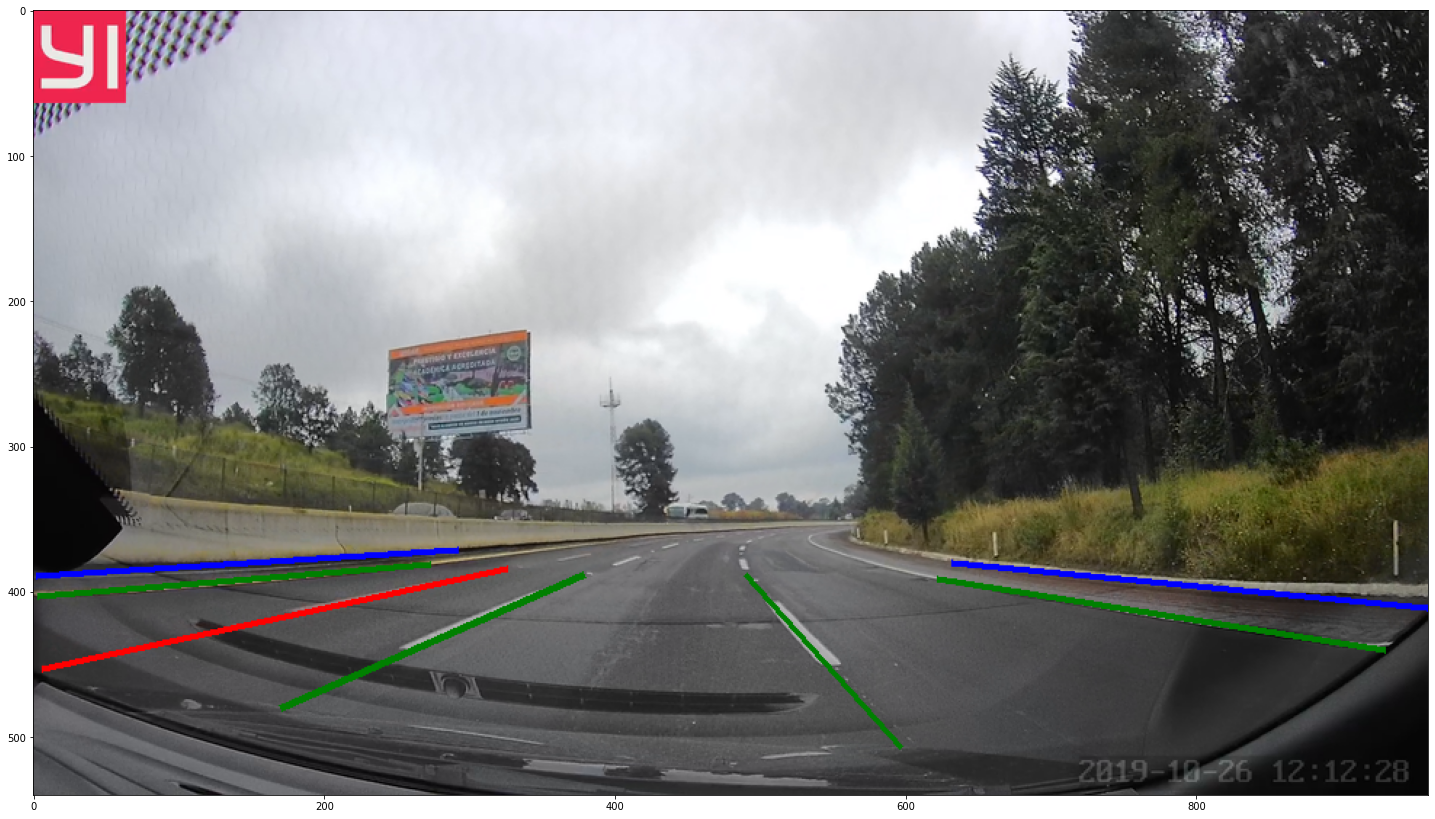

In [172]:
# imagen general

imagen_aleatoria = random.randint(0, len(imagenes))
img = Image.open(images_path + VectorGeneralAplanado[imagen_aleatoria][posicion_nombre])

# imagen sobre la que vamos a dibujar
img1 = ImageDraw.Draw(img)

# Intento 2 - Esperemos que el bueno

for linea in imagenes[imagen_aleatoria][:7]:
    shape = [(linea[5], linea[6]) , (linea[7] , linea[8])]

    # color de la linea
    if linea[1] == 1:
        color = 'green'
    elif linea[2] == 1:
        color = 'red'
    elif linea[3] == 1:
        color = 'blue'
    elif linea[4]  == 1:
        color = 'blue'
    else:
        color = 'red'

    # creamos la linea
    img1.line(shape, fill = color, width = 5)


# despliegue de imagen
fig = plt.figure(figsize=(25,16))
plt.imshow(img)